### State Space Discretization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tempfile
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

#### Q-Learning

In [2]:
env = gym.make('CartPole-v0')
observations = []
for episode in range(100):
    observation = env.reset()
    for t in range(100):
        env.render()
        observations.append(observation)
        action = env.action_space.sample()
        if episode < 25:
            action = 1
        elif episode < 50:
            action = 0
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
x_vals = np.array(observations)[:,0]
xd_vals = np.array(observations)[:,1]
a_vals = np.array(observations)[:,2]
ad_vals = np.array(observations)[:,3]
y = np.zeros_like(x_vals)

[2017-04-02 21:58:12,986] Making new env: CartPole-v0


Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode

In [3]:
x_thres = ((env.env.observation_space.low/2)[0],
           (env.env.observation_space.high/2)[0])
a_thres = ((env.env.observation_space.low/2)[2],
           (env.env.observation_space.high/2)[2])

(-0.15, 0.15)

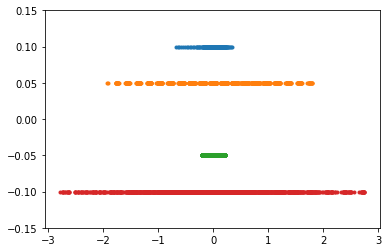

In [4]:
plt.plot(x_vals, y + 0.10, '.')
plt.plot(xd_vals, y + 0.05, '.')
plt.plot(a_vals, y - 0.05, '.')
plt.plot(ad_vals, y - 0.10, '.')

plt.ylim([-0.15, 0.15])

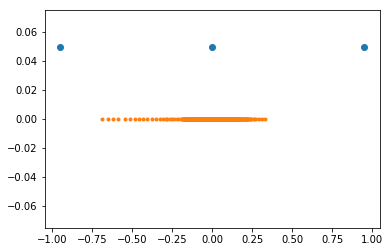

In [5]:
x1 = np.linspace(x_thres[0] + .5, x_thres[1] - .5, 
                 4, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o')
plt.plot(x_vals, y, '.')

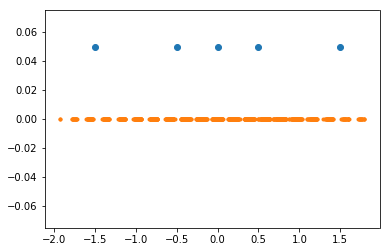

In [6]:
xd1 = np.sort(np.append(np.linspace(-1.5, 1.5, 4, endpoint=True), 0))
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(xd1, y1, 'o')
plt.plot(xd_vals, y, '.')

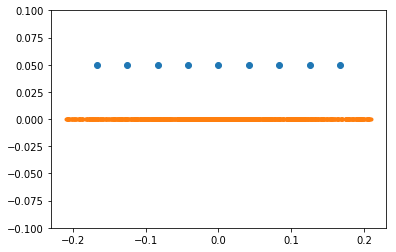

In [7]:
a1 = np.sort(np.linspace(a_thres[0], a_thres[1],
                         10, endpoint=False)[1:])
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o')
plt.plot(a_vals, y, '.')

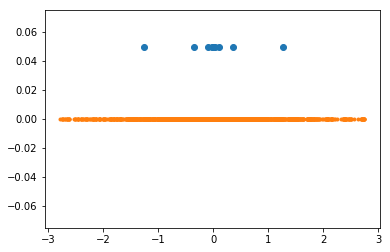

In [8]:
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o')
plt.plot(ad_vals, y, '.')

Digitizing values

In [9]:
a1

array([-0.16755161, -0.12566371, -0.0837758 , -0.0418879 ,  0.        ,
        0.0418879 ,  0.0837758 ,  0.12566371,  0.16755161])

In [10]:
np.digitize(-0.99, a1)

array(0)

In [11]:
np.digitize(0, a1)

array(5)

In [12]:
np.digitize(-0.0001, a1)

array(4)

In [13]:
np.digitize(0.0001, a1)

array(5)

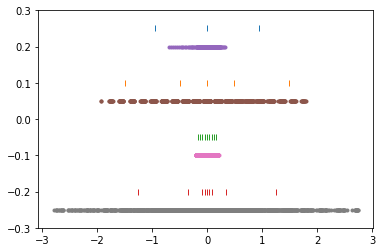

In [14]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.ylim([-0.3, 0.3])

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')

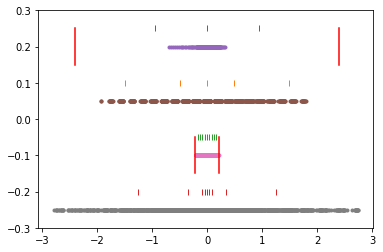

In [15]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')


plt.ylim([-0.3, 0.3])

plt.plot((x_thres[0], x_thres[0]), (0.15, 0.25), 'k-', color='red')
plt.plot((x_thres[1], x_thres[1]), (0.15, 0.25), 'k-', color='red')
plt.plot((a_thres[0], a_thres[0]), (-0.05, -0.15), 'k-', color='red')
plt.plot((a_thres[1], a_thres[1]), (-0.05, -0.15), 'k-', color='red')

In [16]:
def learning_schedule(episode, n_episodes):
    return max(0., min(0.8, 1 - episode/n_episodes))

In [17]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    if np.random.random() < epsilon:
        action = np.random.randint(Q.shape[1])
    else:
        action = np.argmax(Q[state])
    return action, epsilon

In [18]:
def observation_to_state(observation, bins):
    ss = []
    for i in range(len(observation)):
        ss.append(int(np.digitize(observation[i], bins=bins[i])))
    state = int("".join(map(lambda feature: str(int(feature)), ss)))
    return state

In [19]:
def q_learning(env, bins, gamma = 0.99):
    nS = 10 * 10 * 10 * 10
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) - 0.5
    n_episodes = 5000
    
    alphas = []
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        observation = env.reset()
        state = observation_to_state(observation, bins)
    
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, Q, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            observation, reward, done, info = env.step(action)
            nstate = observation_to_state(observation, bins)
            
            alpha = learning_schedule(episode, n_episodes)
            alphas.append(alpha)
            
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q, (alphas, epsilons, states, actions)

In [20]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q, stats = q_learning(env, (x1, xd1, a1, ad1))

[2017-04-02 21:58:23,559] Making new env: CartPole-v0
[2017-04-02 21:58:23,564] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000000.mp4
[2017-04-02 21:58:23,904] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000001.mp4
[2017-04-02 21:58:24,161] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000008.mp4
[2017-04-02 21:58:24,562] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000027.mp4
[2017-04-02 21:58:24,771] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000064.mp4
[2017-04-02 21:58:25,129] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000125.mp4
[2017-04-02 21:58:25,559] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0.3634.video000216.mp4
[2017-04-02 21:58:26,078] Starting new video recorder writing to /tmp/tmpvdek3zuv/openaigym.video.0

In [21]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [22]:
V = np.max(Q, axis=1)
V

array([ 0.11034032,  2.28202232,  8.5119089 , ..., -0.03213468,
        0.48412464,  0.38341096])

In [23]:
V.max()

90.212323364596728

In [24]:
pi = np.argmax(Q, axis=1)
pi

array([0, 1, 0, ..., 1, 1, 1])

In [25]:
env.close()

[2017-04-02 21:58:51,167] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpvdek3zuv')


In [26]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-02 21:58:51,190] [CartPole-v0] Uploading 5000 episodes of training data
[2017-04-02 21:58:52,419] [CartPole-v0] Uploading videos of 14 training episodes (57206 bytes)
[2017-04-02 21:58:52,692] [CartPole-v0] Creating evaluation object from /tmp/tmpvdek3zuv with learning curve and training video
[2017-04-02 21:58:53,054] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_AhsiLjLyTDO1gwgnApVzpQ

****************************************************


In [27]:
alphas, epsilons, states, actions = stats

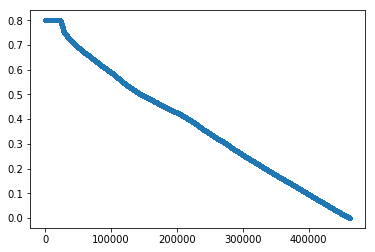

In [28]:
plt.plot(np.arange(len(alphas)), alphas, '.')

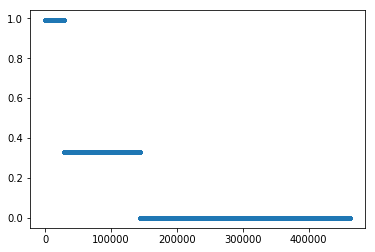

In [29]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

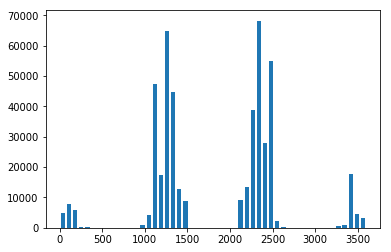

In [30]:
hist, bins = np.histogram(states, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

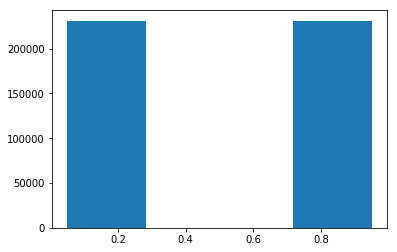

In [31]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Your turn

(-0.15, 0.15)

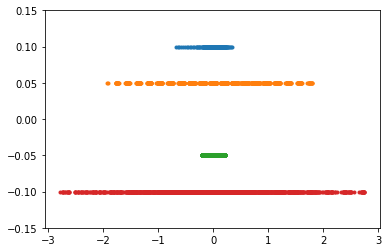

In [32]:
plt.plot(x_vals, y + 0.10, '.')
plt.plot(xd_vals, y + 0.05, '.')
plt.plot(a_vals, y - 0.05, '.')
plt.plot(ad_vals, y - 0.10, '.')

plt.ylim([-0.15, 0.15])

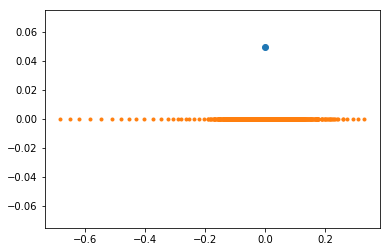

In [33]:
x1 = np.linspace(x_thres[0] + .5, x_thres[1] - .5, 
                 2, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o')
plt.plot(x_vals, y, '.')

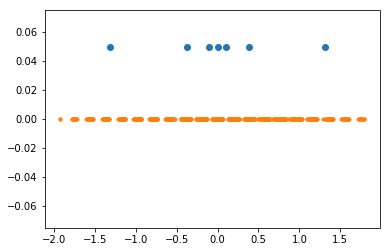

In [34]:
all_vals = np.sort(np.append(
    (np.logspace(-5, 4, 5, endpoint=False, base=2)[1:],
    -np.logspace(-5, 4, 5, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
xd1 = all_vals[idxs]
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(xd1, y1, 'o')
plt.plot(xd_vals, y, '.')

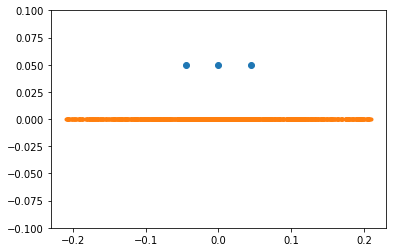

In [35]:
all_vals = np.sort(np.append(
    (np.logspace(-6, 0.01, 4, endpoint=False, base=2)[1:],
    -np.logspace(-6, 0.01, 4, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < a_thres[1] - 0.1)
a1 = all_vals[idxs]
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o')
plt.plot(a_vals, y, '.')

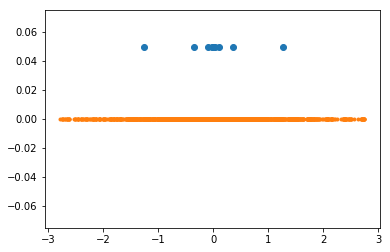

In [36]:
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o')
plt.plot(ad_vals, y, '.')

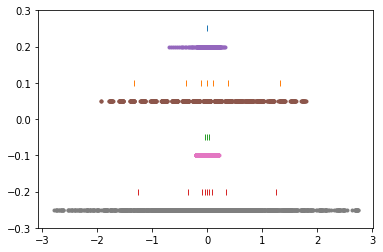

In [37]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.ylim([-0.3, 0.3])

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')

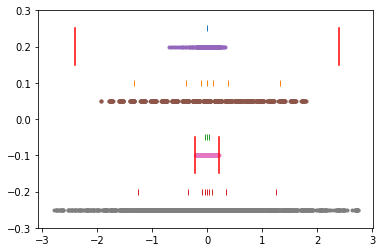

In [38]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')


plt.ylim([-0.3, 0.3])

plt.plot((x_thres[0], x_thres[0]), (0.15, 0.25), 'k-', color='red')
plt.plot((x_thres[1], x_thres[1]), (0.15, 0.25), 'k-', color='red')
plt.plot((a_thres[0], a_thres[0]), (-0.05, -0.15), 'k-', color='red')
plt.plot((a_thres[1], a_thres[1]), (-0.05, -0.15), 'k-', color='red')

In [39]:
def learning_schedule(episode, n_episodes):
    return max(0., min(0.8, 1 - episode/n_episodes))

In [40]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    if np.random.random() < epsilon:
        action = np.random.randint(Q.shape[1])
    else:
        action = np.argmax(Q[state])
    return action, epsilon

In [41]:
def observation_to_state(observation, bins):
    ss = []
    for i in range(len(observation)):
        ss.append(int(np.digitize(observation[i], bins=bins[i])))
    state = int("".join(map(lambda feature: str(int(feature)), ss)))
    return state

In [42]:
def q_learning(env, bins, gamma = 0.99):
    nS = 10 * 10 * 10 * 10
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) - 0.5
    n_episodes = 5000
    
    alphas = []
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        observation = env.reset()
        state = observation_to_state(observation, bins)
    
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, Q, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            observation, reward, done, info = env.step(action)
            nstate = observation_to_state(observation, bins)
            
            alpha = learning_schedule(episode, n_episodes)
            alphas.append(alpha)
            
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q, (alphas, epsilons, states, actions)

In [43]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q, stats = q_learning(env, (x1, xd1, a1, ad1))

[2017-04-02 21:58:57,455] Making new env: CartPole-v0
[2017-04-02 21:58:57,469] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000000.mp4
[2017-04-02 21:58:57,932] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000001.mp4
[2017-04-02 21:58:58,170] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000008.mp4
[2017-04-02 21:58:58,427] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000027.mp4
[2017-04-02 21:58:58,711] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000064.mp4
[2017-04-02 21:58:58,973] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000125.mp4
[2017-04-02 21:58:59,319] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1.3634.video000216.mp4
[2017-04-02 21:58:59,773] Starting new video recorder writing to /tmp/tmpmkwghiu4/openaigym.video.1

In [44]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [45]:
V = np.max(Q, axis=1)
V

array([  0.14840227,  42.53841636,  52.94672826, ...,   0.25170908,
         0.29312305,   0.46778605])

In [46]:
V.max()

86.837184465801627

In [47]:
pi = np.argmax(Q, axis=1)
pi

array([1, 1, 0, ..., 0, 0, 0])

In [48]:
env.close()

[2017-04-02 21:59:30,152] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpmkwghiu4')


In [49]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-02 21:59:30,177] [CartPole-v0] Uploading 5000 episodes of training data
[2017-04-02 21:59:31,154] [CartPole-v0] Uploading videos of 14 training episodes (72394 bytes)
[2017-04-02 21:59:32,376] [CartPole-v0] Creating evaluation object from /tmp/tmpmkwghiu4 with learning curve and training video
[2017-04-02 21:59:32,582] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_GDMU3XnQxi3N0vnynQNbg

****************************************************


In [50]:
alphas, epsilons, states, actions = stats

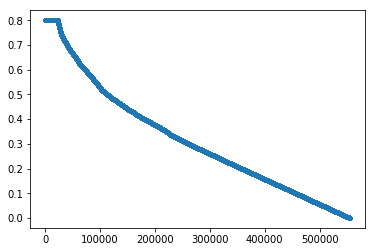

In [51]:
plt.plot(np.arange(len(alphas)), alphas, '.')

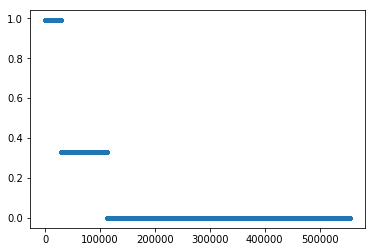

In [52]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

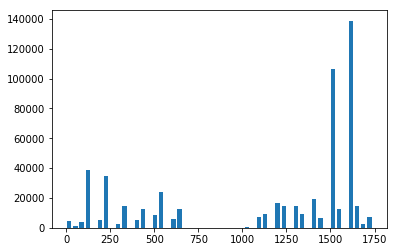

In [53]:
hist, bins = np.histogram(states, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

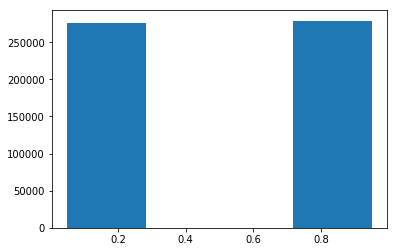

In [54]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()